# Import Library

In [1]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import pandas as pd
import numpy as np 
#
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Data/SalesData.xlsx')

In [14]:
# DataSet의 Columns Name 변경
df.columns = ['Date', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']
# DataFrame 출력 format 설정_ 과학적 표기법 사용X
pd.options.display.float_format = '{:.2f}'.format
df

,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...,...
939,2019-12-27,3755000,3432600,25,150200.00,0.09,42,13
940,2019-12-28,7799000,7174700,52,149980.77,0.08,42,17
941,2019-12-29,11227900,10488900,75,149705.33,0.07,42,19
942,2019-12-30,5672000,5313000,38,149263.16,0.06,42,16


In [ ]:
#Date column YY-MM-DD 분할 Column 생성
df['YY'] = 'temp'
df['MM'] = 'temp'
df['DD'] = 'temp'
for i in range(len(df)):
  tstr = df.iloc[i]['Date']
  [yy, mm, dd] = str(tstr).split("-")
  dd = dd.split(" ")[0]
  df['YY'].iloc[i] = yy
  df['MM'].iloc[i] = mm
  df['DD'].iloc[i] = dd

df = df[['Date', 'YY', 'MM', 'DD', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']]
df

# 2021-01-18 


## Dataset 속성 파악

### 기술통계

In [15]:
df.describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,8407918.43,7658885.36,57.44,147049.30,0.09,45.87,13.03
std,4959462.28,4504263.47,34.17,9739.52,0.08,5.94,4.42
min,219000.00,163400.00,1.00,124250.00,0.00,28.00,2.00
25%,4998750.00,4525550.00,34.00,139000.00,0.04,45.00,10.00
50%,7057500.00,6462550.00,48.00,144814.89,0.07,46.00,13.00
75%,10891250.00,10195725.00,75.00,152967.27,0.13,49.00,16.00
max,37391000.00,25800000.00,269.00,219000.00,0.65,56.00,30.00


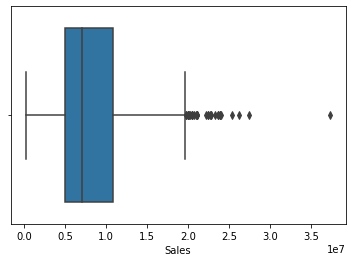

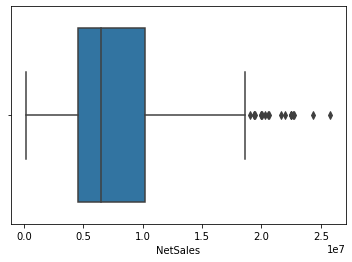

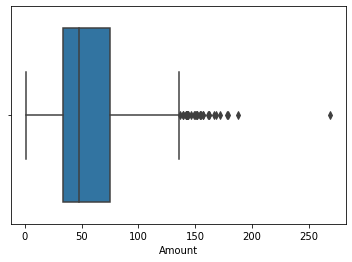

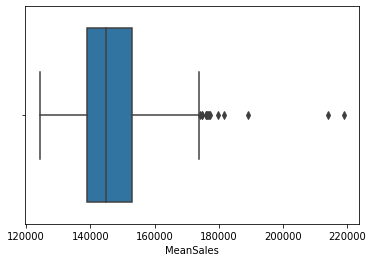

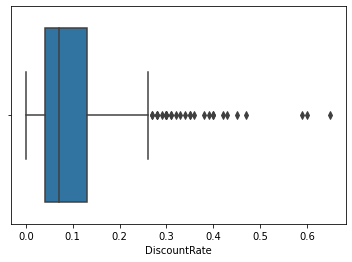

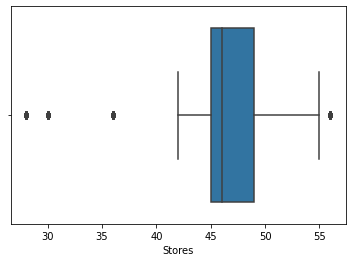

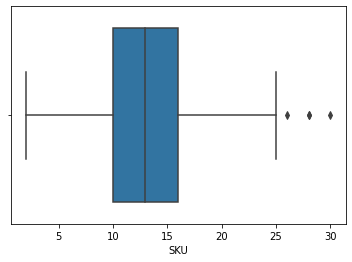

In [36]:
for tempcol in list(df.columns)[1:]:
  subplot()
  ns.boxplot(data=df, x=tempcol)
  plt.show()

### 상관관계 분석

In [6]:
tempdf = df[['매출', '순매출', '수량', '평균소비자가', '할인율', 'Stores', 'SKU']]
tempdf

,매출,순매출,수량,평균소비자가,할인율,Stores,SKU
0,2502000,2383400,18,139000.00,0.05,48,4
1,6086000,5984800,45,135244.44,0.02,48,8
2,12778000,12510600,92,138891.30,0.02,48,8
3,10842000,10631400,78,139000.00,0.02,48,7
4,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...
939,3755000,3432600,25,150200.00,0.09,42,13
940,7799000,7174700,52,149980.77,0.08,42,17
941,11227900,10488900,75,149705.33,0.07,42,19
942,5672000,5313000,38,149263.16,0.06,42,16


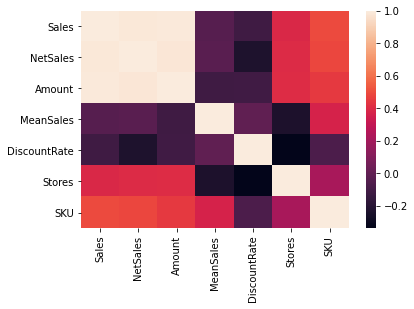

In [33]:
%matplotlib inline
sns.heatmap(df.corr())
plt.show()

### 연도별 Sales Value 기술통계

In [65]:
df.loc[df['YY']=='2017'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,214.00,214.00,214.00,214.00,214.00,214.00,214.00
mean,9570067.76,8955224.77,67.72,141101.54,0.06,47.98,9.69
std,5018895.08,4713668.44,35.10,4120.43,0.04,2.68,2.13
min,2403000.00,2357200.00,17.00,132642.86,0.00,43.00,4.00
25%,5699000.00,5365675.00,41.00,139000.00,0.04,46.00,8.00
50%,8342000.00,7627250.00,58.50,139000.00,0.06,48.00,10.00
75%,12371000.00,11630925.00,89.00,144081.63,0.08,50.00,11.00
max,23898000.00,22708600.00,172.00,152469.39,0.33,52.00,17.00


In [66]:
df.loc[df['YY']=='2018'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,365.00,365.00,365.00,365.00,365.00,365.00,365.00
mean,8530174.25,7567555.01,59.45,142835.28,0.12,46.68,13.15
std,5320772.38,4610200.81,36.84,6287.28,0.08,7.02,4.79
min,556000.00,486500.00,4.00,131131.58,0.00,28.00,2.00
25%,4830000.00,4424200.00,34.00,139000.00,0.05,45.00,10.00
50%,7212000.00,6392500.00,50.00,140052.63,0.10,47.00,13.00
75%,11249000.00,10319400.00,77.00,145557.38,0.16,49.00,16.00
max,37391000.00,24305580.00,269.00,164225.23,0.60,56.00,28.00


In [67]:
df.loc[df['YY']=='2019'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,365.00,365.00,365.00,365.00,365.00,365.00,365.00
mean,7604292.88,6990170.14,49.40,154750.50,0.09,43.81,14.87
std,4383312.22,4106094.61,28.55,9909.82,0.08,5.52,3.88
min,219000.00,163400.00,1.00,124250.00,0.00,30.00,4.00
25%,4668000.00,4169800.00,30.00,148705.88,0.04,42.00,12.00
50%,6459000.00,6048600.00,43.00,153651.16,0.07,45.00,15.00
75%,9379000.00,8743800.00,61.00,159444.44,0.12,46.00,17.00
max,27512000.00,25800000.00,178.00,219000.00,0.65,50.00,30.00


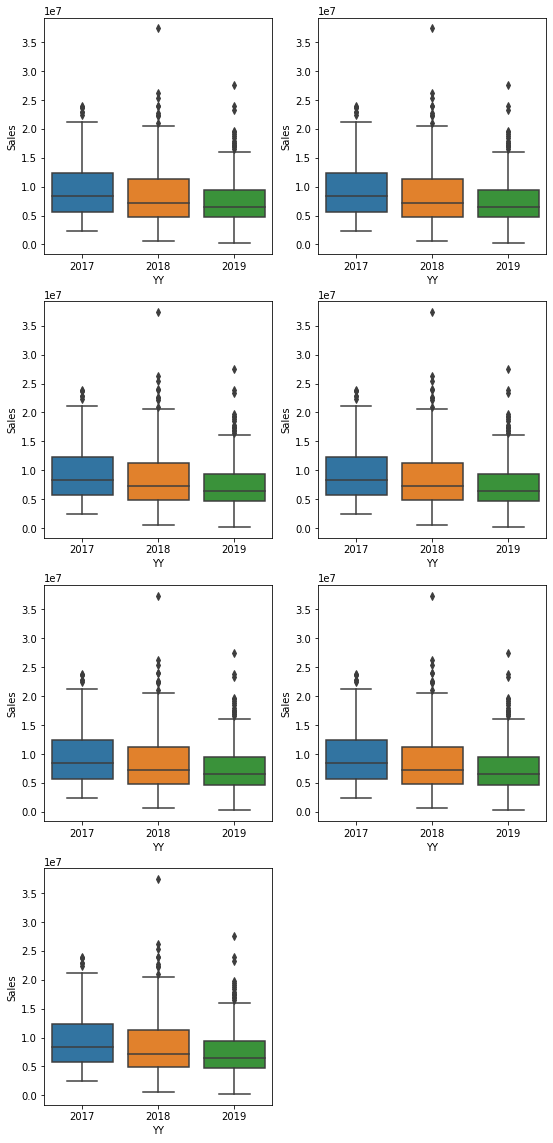

In [82]:
tlst =['Sales', 'NetSales', 'MeanSales', 'Amount', 'Stores', 'DiscountRate', 'SKU']
plt.figure(figsize=(9,20))
for i in range(len(tlst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, x='YY', y=tptxt)

plt.show()